# Week 3

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [300]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [302]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Estimates for expected returns

In principle, the **Modern Portfolio Theory** (the mean-variance approach of **Markowitz**) offers a solution to this problem once the expected returns and covariances of the assets are known. While Modern Portfolio Theory is an important theoretical advance, **its application has universally encountered a problem**: although the covariances of a few assets can be adequately estimated, **it is difficult to come up with reasonable estimates of expected returns**.

In particular, recall that Markowitz portfolio allocation approach takes in input the set of expected returns and expected volatilities of the assets we are interested in, and gives in output the set of optimal weights in these assets. 

The problem is that **very small changes in the expected returns normally result in large changes in output weights**. Of course, this represent a problem (also because we cannot pretend to invest today in a portoflio by relying on exact past returns and volatilities as they are not likely to be the same in future).

In general, **sample based information** such as the returns computed using sampled past data **are close to useless** 

Let $N$ be the number of assets in our portfolio.

#### Shrinked expected returns 

A very basic estimate for expected returns is a simple modificiation of sample means. Let 
$$
\mu_i := \frac{1}{T} \sum_{t=1}^{T} r_{t}^{i} 
\quad\text{and}\quad
\bar{\mu} := \frac{1}{N} \sum_{i=1}^N \mu_i, 
$$
be the **sample mean return** of each asset 
and the **grand sample mean** (i.e., the mean of the computed mean returns), respectively. 
The sample mean might be improved by **shrinking** the individual means to the grand sample mean:
$$
\hat{\mu}_i := \delta \bar{\mu} + (1-\delta)\mu_i,
$$
given a shrinking factor $\delta\in [0,1]$ (when $\delta=1$ we are saying that all asset's returns are equal to the grand sample mean).

In [5]:
# these are the \mu_i
asset_means_rets = np.array([11.1, 12.3, 8.4, 15.3, 5.6, 9.7])/100

# this is \bar{\mu} 
grand_sample_mean = asset_means_rets.mean()

# shrinked mean
delta = 0.5
shrinked_mean_ret = delta * grand_sample_mean + (1-delta)* asset_means_rets

print("sample means:   {}%" .format( np.round(asset_means_rets*100,2)) )
print("shrinked means: {}%" .format( np.round(shrinked_mean_ret*100,2) ) )

sample means:   [11.1 12.3  8.4 15.3  5.6  9.7]%
shrinked means: [10.75 11.35  9.4  12.85  8.   10.05]%


### Relying on agnostic priors

Recall that the **expected return and the volatility of a portfolio** of $N$ assets are given by:
$$
\mu_p := \mathbf{w}^T\mathbf{\mu} = \sum_{i=1}^N w_i \mu_i
\quad\text{and}\quad
\sigma_p = (\mathbf{w}^T \Sigma \mathbf{w})^{1/2}, 
$$
where $\mathbf{w}:=(w_1,\dots,w_N)^T$ is the vector of weigths, 
$\mathbf{\mu}:=(\mu_1,\dots,\mu_N)$, where $\mu_i=\mathbb{E}[r_i]$ for each $i=1,\dots,N$ is the expected return of asset $i$, and $\Sigma$ is the expected covariance matrix of the assets.

The vector of expected returns $\mathbf{\mu}:=(\mu_1,\dots,\mu_N)$ is what we are mainly concerned about. 

We have to introduce some, ideally **economically motivated, priors** since using sample based expected returns is not going to work fine.


Let us suppose that we are interested in the maximum sharpe ratio portfolio, i.e., the portoflio or which the sharpe ratio:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i (\mu_i - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} },
$$
is maximum.

#### First agnostic prior: all returns are equal
A very first agnostic prior is assuming that **all expected returns are going to be equal**, for example, equal to the grand sample mean. Of course we know that such assumption would be wrong. However, 
in this case we have:
$$
\mu_i - r_f = \hat{\mu} - r_f \qquad \forall\; i,
$$
hence maximizing the sharpe ratio means, indeed, minimizing the volatility:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i (\hat{\mu} - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= \frac{ \hat{\mu} - r_f }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }.
$$

#### Second agnostic prior: sharpe ratios are all equal
A second agnostic prior would be assuming that sharpe ratios are all equal, in particular, this means assuming that the excess 
return $\mu_i-r_f$ of each asset is proportional to the corresponding volatility $\sigma_i$:
$$
\mu_i - r_f = \lambda \sigma_i 
\qquad  \forall\; i, 
$$
where the constant of proportionality $\lambda$ is sharpe ratio supposed to be the same for each asset. In this case, the assumption we are making is simply that **more volatile assets are going to have larger expected returns**. The sharpe ratio of the portfolio becomes:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i \lambda \sigma_i}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= \lambda \frac{ \sum_{i=1}^N w_i \sigma_i }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }. 
$$
The ratio between the weigthed volatilities and the volatility of the portfolio is known as the **diversification ratio**.

**EXAMPLE:** 
What is the Sharpe ratio of a portfolio of an equally-weighted portfolio of two stocks with volatility equal to $20\%$ and $30\%$, respectively, and a pairwise correlation $0.6$, assuming that they 
both have a Sharpe ratio of $\lambda = 70\%$?

First of all, we have $\sigma_1=0.2$, $\sigma_2=0.3$ and $\rho_{12}=0.6$. The covariance of the stocks is $\text{Cov}(r_1,r_2) = \rho_{12}\sigma_1\sigma_2 = 0.6\cdot 0.2\cdot 0.3 = 0.036$. Then:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \lambda \frac{ \sum_{i=1}^2 w_i \sigma_i }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} } 
= 0.7 \frac{ 0.5\cdot 0.2 + 0.5\cdot 0.3 }{ 
\sqrt{
(0.5, 0.5) 
\begin{pmatrix}
0.04 & 0.036 \\
0.036 & 0.09 
\end{pmatrix}
\begin{pmatrix}
0.5 \\
0.5
\end{pmatrix}
} 
}
=
0.7 \frac{ 0.25 }{ \sqrt{0.0505} } = 77.87\%.
$$

Do we believe that all stocks and all components have the same Sharpe ratio? 
It is a very strong assumption and we have reasons to believe that not all of risk is rewarded. 
In fact, asset pricing theory suggests that **only the systematic component is rewarded** and that 
the specific risk is not rewarded because it can be diversified away. In other words, asset pricing theory suggests that **we should not be rewarded for a piece of risks that we could have diversified away in the first place** and we should instead assume that 
**there is a relationship between excess expected return and (only) the systematic part of volatility**. 

Therefore, we want to **decompose volatility in terms of specific risk and systematic risk**, 
and come up with a better **estimate for expected returns by relating it to systematic risk**. 

We could do this using a **factor model**.

#### Using a factor model to estimate (excess) returns

The simplest factor model that we can use is the **CAPM**. Recall that in the CAPM the expected escess return of an asset was proportional to the excess return of the market:
$$
\mu_i - r_f = \beta_i(\mu_m -r_f)
\qquad \forall \; i,
$$
where $\beta_i$ is the constant of proportionality. This is equivalent to impose that the following ratio:
$$
\text{TR}_i := \frac{\mu_i - r_f}{\beta_i} = \mu_m -r_f,
\qquad \forall \; i
$$
called the **Treynor ratio** is the same for all stocks and equal to the excess return of the market $\mu_m -r_f$. If we accept this model, then the maximum sharpe ratio portfolio would has a sharpe ratio equal to:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p}
= \frac{ \sum_{i=1}^N w_i (\mu_i - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= (\mu_m - r_f) \frac{ \sum_{i=1}^N w_i \beta_i}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
$$
where the numerator is the $\beta$ of the portfolio, that is, the weigthed average of $\beta_i$. 

Again, we probably do not want to rely on single-factor models such as the CAMP. 
Below, we consider the $30$ industry portfolios and compare the annualized returns obtained simply using the historical data and using the CAMP model:

In [294]:
# Load data
nind = 30
start = "2013"
ind_rets = erk.get_ind_file(filetype="rets", nind=nind, ew=True)[start:]
fff = erk.get_fff_returns()[start:]
mkt_excess_rets = fff[["Mkt-RF"]]

In [295]:
# compute the excess returns of all industries
rf = pd.DataFrame().reindex_like(ind_rets)
for col in rf.columns:
    rf[col] = fff["RF"].values
ind_exc_rets = ind_rets - rf 
# compute the annualized "historic" mean return
historic_mean = erk.annualize_rets( ind_exc_rets, periods_per_year=12 )
historic_mean.head()

Food     0.114591
Beer     0.203339
Smoke    0.190788
Games    0.138539
Books    0.099739
dtype: float64

In [296]:
# computing beta for each industry  
industries = ind_rets.columns
betas = []
for industry in industries:
    ind_excess_rets = ind_rets[industry] - fff["RF"].values
    lm = erk.linear_regression(ind_excess_rets, mkt_excess_rets)
    betas.append( lm.params[0] )
betas = pd.DataFrame(betas, index=ind_rets.columns, columns=["Mkt-RF"])
# now estimate excess returns of the industries using the CAPM model: beta * exc_ret_of_the_market
capm_rets = []
for industry in betas.index:
    capm_rets.append( erk.annualize_rets( betas.loc[industry] * mkt_excess_rets , periods_per_year=12 )[0] )
capm_rets = pd.Series(capm_rets, index=betas.index)
capm_rets.head()

Food     0.089289
Beer     0.062788
Smoke    0.059317
Games    0.133733
Books    0.147150
dtype: float64

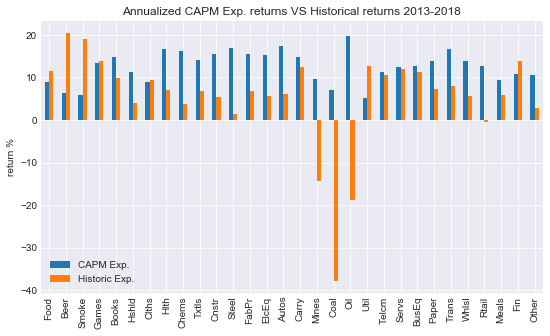

In [297]:
A = pd.concat([capm_rets, historic_mean], axis=1) * 100
A.columns = ["CAPM Exp.","Historic Exp."]
ax = A.plot.bar(grid=True, figsize=(9,5), title="Annualized CAPM Exp. returns VS Historical returns {}-2018".format(start))
ax.set_ylabel("return %")
plt.show()

Observe that the CAPM expected returns are all positives and are contained in a much smaller range of returns. 


Black–Litterman overcame this problem by not requiring the user to input estimates of expected return; instead it assumes that the initial expected returns are whatever is required so that the equilibrium asset allocation is equal to what we observe in the markets. The user is only required to state how his assumptions about expected returns differ from the markets and to state his degree of confidence in the alternative assumptions. From this, the Black–Litterman method computes the desired (mean-variance efficient) asset allocation.

In general, when there are portfolio constraints - for example, when short sales are not allowed - the easiest way to find the optimal portfolio is to use the Black–Litterman model to generate the expected returns for the assets, and then use a mean-variance optimizer to solve the constrained optimization problem



Black-Litterman model is based on an assumption that asset returns have greatest impact to portfolio weightings in mean-variance optimization. It is therefore attempting to reverse-engineer these returns from index constituents rather than relying on historical data. This results into several advantages including but not limited to:
Intuitive portfolios with weightings not too much different from benchmark indices.
Ability to incorporate custom views
Lower tracking error and reliance on historical data
Greater stability of efficient frontier and better diversification